## Importanto as bibliotecas:

In [317]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

import random

## Configuracoes iniciais:

In [318]:
transform = transforms.Compose([
    transforms.ToTensor()
])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

image_dims_color = 28*28
batch_size = 128

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

cuda


## Declarando a classe VAE e funcao de perda:

In [319]:
class VAE(nn.Module):
  
    def __init__(self):
        super(VAE, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 16, 3)
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1_mu = nn.Linear(12 * 12 * 16, 20)
        self.fc1_sig = nn.Linear(12 * 12 * 16, 20)
        self.fc2 = nn.Linear(20, 12 * 12 * 16)
        self.up_sample = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv3 = nn.ConvTranspose2d(16, 32, 3)
        self.conv4 = nn.ConvTranspose2d(32, 1, 3)
  
    def encode(self,x):
        a1 = F.relu(self.conv1(x))
        a2 = F.relu(self.conv2(a1))
        mx_poold = self.max_pool(a2)
        a_reshaped = mx_poold.reshape(-1 , 12 * 12 * 16)
        a_mu = self.fc1_mu(a_reshaped)
        a_logvar = self.fc1_sig(a_reshaped)
        return a_mu, a_logvar
  
    def decode(self,z):
        a3 = F.relu(self.fc2(z))
        a3 = a3.reshape(-1, 16, 12, 12)
        a3_upsample = self.up_sample(a3)
        a4 = F.relu(self.conv3(a3_upsample))
        a5 = torch.sigmoid(self.conv4(a4))
        return a5
  
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
  
    def forward(self,x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1,784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))

## Treinamento:

In [320]:
num_epochs = 60
print_per = 100
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    loss_record = []
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch+1, i, print_loss))
            loss_record.append(print_loss)
            print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))
    torch.save(model.state_dict(), f'./epochs_vae_conv/vae_conv_epoch_{epoch + 1}.pth')

Epoch : 1 , Minibatch : 0 Loss = 74146.8359


KeyboardInterrupt: 

## Resultados:

/tmp/ipykernel_23003/3083393284.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./epochs_vae_conv/vae_conv_epoch_60.pth'))


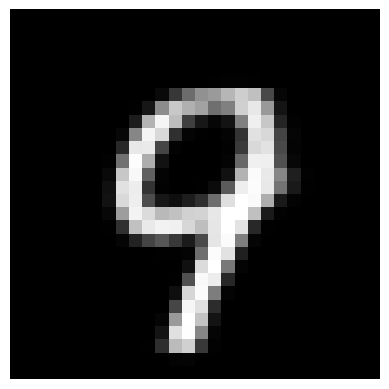

In [355]:
def generate_samples(model, device):
    model.load_state_dict(torch.load(f'./epochs_vae_conv/vae_conv_epoch_60.pth'))
    model = model.to(device)
    cap = 0
    limit = 0

    with torch.no_grad():
        for batch in train_loader:
            images, _ = batch
            for image in images:
                if cap > limit: return
                image = image.unsqueeze(0).to(device)
                reconstruction, *_ = model(image)
                sample = reconstruction.squeeze().cpu().numpy()

                plt.imshow(sample, cmap='gray')
                plt.axis("off")
                plt.show(block=True)
                cap += 1

generate_samples(model, device)

/tmp/ipykernel_23003/572196381.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./epochs_vae_conv/vae_conv_epoch_60.pth'))


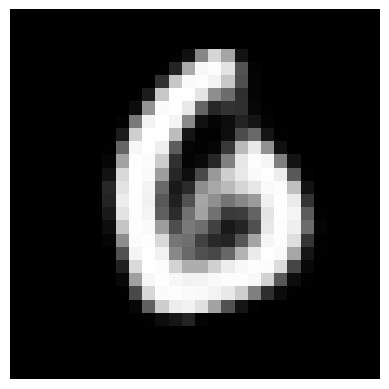

In [421]:
def generate_image(model, device):
    model = model.to(device)
    model.eval()
    model.load_state_dict(torch.load(f'./epochs_vae_conv/vae_conv_epoch_60.pth'))
    with torch.no_grad():
        z = torch.randn(1, 20).to(device)
        sample = model.decode(z).cpu()
        sample = sample.view(28, 28)
        return sample

image = generate_image(model, device)
plt.imshow(image.view(28, 28), cmap='gray')
plt.axis('off')
plt.show()